In [1]:
import numpy as np 
import pandas as pd

train_file = np.load("C:\\Users\\sherr\\Documents\\grad\\251b\\data\\train.npz")
data = train_file['data']
print("train_data's shape", data.shape)

test_file = np.load("C:\\Users\\sherr\\Documents\\grad\\251b\\data\\test_input.npz")
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


The training set should be of shape (10000, 50, 110, 6). There are 10,000 training scenes, each scene contains 50 agents' trajectories over 110 time steps, and each time step has 6 dimensions.

Columns
The 6 dimensions are, respectively:

position_x: x-coordinate of the agent's position <br>
position_y: y-coordinate of the agent's position <br>
velocity_x: x-component of the agent's velocity <br>
velocity_y: y-component of the agent's velocity <br>
heading: heading angle of the agent in radians <br>
object_type: encoded object type. The integers indexes this array: <br>
['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown'] <br>

For many of the agents, their trajectory is not complete. In the case that this happens or when there are less than 50 agents in the scene, we pad the matrix with zeros. (so don't be surprised when you see a lot of zeros!) <br>

Your task is to predict the ego vehicle (agent index 0)'s trajectory. We will pre in a scene given the first 50 time steps (5 seconds) to predict the next 60 time steps. <br>
This means that the test set input has shape (2100, 50, 50, 6) (2100 scenes, 50 agents, 50 time steps input, 6 dimensions), and you are expected to upload a csv file of shape (2100 * 60, 2) (2100 scenes, 1 ego agent, 60 time steps prediction, 2 dimensions - just x and y). 

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

train_data, val_data = train_test_split(data, test_size=0.20, random_state=42)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

In [3]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32, device=device),
            origin=torch.tensor(origin, dtype=torch.float32, device=device).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32, device=device),
        )
        return data_item

In [4]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

# N = len(train_data)
# val_size = int(0.1 * N)
# train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(val_data, scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

In [5]:
test = nn.Embedding(10, embedding_dim = 8)
ids = torch.from_numpy(train_data[:,:,:,5]).long()
print(train_data.shape)
print(test(ids).shape)
train_data[:,:,:,:5].shape

(8000, 50, 110, 6)
torch.Size([8000, 50, 110, 8])


(8000, 50, 110, 5)

In [6]:
test = np.zeros((5,10,2))
tests = np.ones((5,2))
np.concatenate([test,tests[:,np.newaxis,:]],axis=1).shape

(5, 11, 2)

In [28]:
MAX_LENGTH = 60

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size,embedding_size):
        super(Encoder, self).__init__()
        self.embeddings = nn.Embedding(10, embedding_dim=embedding_size)
        self.fc1 = nn.Linear(5+embedding_size,hidden_size)
        self.LSTM1 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.LSTM2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.leakyRelu = nn.LeakyReLU()
        
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.3)
        
    def forward(self, input):
        input = input.reshape(-1, 50, 50, 6)
        input = input[:,0,:,:]
        ids = input[:,:,5].long()
        embeddings = self.embeddings(ids)
        embinput = torch.cat([input[:,:,:5],embeddings], dim=-1)
        #embinput = embinput.view(embinput.shape[0]*embinput.shape[1],embinput.shape[2],embinput.shape[3])
        
        d1 = self.fc1(embinput)
        rd1 = self.leakyRelu (d1)
        droppedrd1 = self.drop1(rd1)

        l1, states = self.LSTM1(droppedrd1)
        d2 = self.fc2(l1)
        rd2 =self.leakyRelu (d2)
        droppedrd2 = self.drop2(rd2)

        out, hidden = self.LSTM2(droppedrd2)
        
        #input = input.reshape(-1, 50, 50, 6)
        #input = input[:,0,:,:]
        
        #out, hidden = self.gru(input)
        #out = self.drop(out)
        return out, states, hidden#,embeddings (future testing)
"""
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size*2,hidden_size,128)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, dec_hidden)
        # encoder_outputs: (batch, seq_len, enc_hidden)

        seq_len = encoder_outputs.size(1)
        
        hidden = hidden[-1].squeeze().unsqueeze(1).repeat(1, seq_len, 1)  # (batch, seq_len, dec_hidden)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch, seq_len, dec_hidden)
        energy = energy.transpose(1, 2)  # (batch, dec_hidden, seq_len)

        v = self.v.unsqueeze(0).unsqueeze(1)  # (1, 1, dec_hidden)
        v = v.repeat(encoder_outputs.size(0), 1, 1)  # (batch, 1, dec_hidden)

        attention_weights = torch.bmm(v, energy).squeeze(1)  # (batch, seq_len)
        return torch.softmax(attention_weights, dim=1)
"""
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        #self.Attention = Attention(hidden_size)
        self.LSTM1 = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.LSTM2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.drop1 = nn.Dropout(p=0.15)
        self.leakyRelu = nn.LeakyReLU()
        
        #self.drop2 = nn.Dropout(p=0.1)

    def forward(self, input, encoder_hidden1,encoder_hidden2):
        #print(input.shape)
        input = input.reshape(-1, 50, 50, 6)
        #print(input.shape)
        
        decoder_input = input[:,0,-1,:2].unsqueeze(1)
        #decoder_input = input[:, -1:, :2]#[:,0,-1,:2].unsqueeze(1)
        #oriput = input#t[:,0,:,:2]
        
        #print(decoder_input.shape,"dec")
        
        #attn_weights = self.Attention(encoder_hidden2[0], oriput)  # (batch, seq_len)
        #context = torch.bmm(attn_weights.unsqueeze(1), oriput)  # (batch, 1, enc_hidden)
        #other types of pooling, max/attention test?
        decoder_hidden1 = encoder_hidden1#(encoder_hidden1[0].view(1,-1,50,256).mean(dim=2),encoder_hidden1[1].view(1,-1,50,256).mean(dim=2))
        decoder_hidden2 =encoder_hidden2 #(encoder_hidden2[0].view(1,-1,50,256).mean(dim=2),encoder_hidden2[1].view(1,-1,50,256).mean(dim=2))
        decoder_outputs = []

        #print(decoder_hidden1[0].shape,encoder_hidden1[0].view(-1,50,256).shape)
        for i in range(MAX_LENGTH):
            decoder_out, decoder_hidden1,decoder_hidden2  = self.forward_step(decoder_input, decoder_hidden1,decoder_hidden2)
            decoder_outputs.append(decoder_out)

            
            #attn_weights = self.Attention(decoder_hidden2[0], oriput)  # (batch, seq_len)
            #context = torch.bmm(attn_weights.unsqueeze(1), oriput)  # (batch, 1, enc_hidden)
            decoder_input = decoder_out.detach() # detach from history as input
           
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs
        
    def forward_step(self, input, hidden1,hidden2):
        #print("input",input.shape)


        # Concatenate context with input
        #rnn_input = torch.cat((input, context), dim=2)  # (batch, 1, output+enc_hidden)
        #print(rnn_input.shape)
        out, states = self.LSTM1(input, hidden1)
        out = self.fc1(out)
        out = self.leakyRelu (out)
        out = self.drop1(out)
        out, hidden = self.LSTM2(out, hidden2)
        out = self.fc2(out)
        #out = self.drop2(out)
        
        return out,states, hidden

In [29]:
input_size = 6
hidden_size = 256
output_size = 2
embedding_size=8

# Create the model
encoder = Encoder(input_size, hidden_size,embedding_size).to(device)
decoder = Decoder(hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=1e-4)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001, weight_decay=1e-4)

encoder_scheduler = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=20, gamma=0.25) # You can try different schedulers
decoder_scheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=20, gamma=0.25) # You can try different schedulers

early_stopping_patience = 10

def get_val_loss(encoder, decoder, val_dataloader):
    
    encoder.eval()
    decoder.eval()

    total_val_loss = 0
    total_val_mse = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            
            encoder_outputs, encoder_hidden, eh2 = encoder(batch.x)
            pred = decoder(batch.x, encoder_hidden,eh2)
            #pred = decoder(encoder_outputs, encoder_hidden,eh2)
           
            y = batch.y.view(batch.num_graphs, 60, 2)
            #print(pred.shape)
            total_val_loss += criterion(pred, y).item()

            # show MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            total_val_mse += nn.MSELoss()(pred, y).item()
            
    val_loss = total_val_loss / len(val_dataloader)
    val_mse = total_val_mse / len(val_dataloader)
            
    print(f'Validation Loss: {val_loss:.4f} Validation MSE: {val_mse:.4f}')
    return val_loss, val_mse
    
def train_model(encoder, decoder, train_loader, val_loader, batch_size=64, epochs=10):

    train_loss = []
    val_loss = []
    val_mse = []

    best_val_loss = float('inf')
    no_improvement = 0
    
    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        
        for batch in tqdm.tqdm(train_loader):

            batch = batch.to(device)

            batch_X = batch.x
            batch_y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Zero the parameter gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            encoder_outputs, encoder_hidden1,encoder_hidden2 = encoder(batch_X)
            decoder_outputs = decoder(batch_X, encoder_hidden1,encoder_hidden2)
            #decoder_outputs = decoder(encoder_outputs, encoder_hidden1,encoder_hidden2)

            # Calculate loss
            loss = criterion(decoder_outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            running_loss += loss.item()
        
        # Print epoch statistics
        train_loss.append(running_loss/len(train_loader))
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}')
        
        v_loss, v_mse = get_val_loss(encoder, decoder, val_loader)
        val_loss.append(v_loss)
        val_mse.append(v_mse)

        encoder_scheduler.step()
        decoder_scheduler.step()

        if v_loss < best_val_loss - 1e-3:
            best_val_loss = v_loss
            no_improvement = 0
            torch.save(encoder.state_dict(), "encoder_best_model.pt")
            torch.save(decoder.state_dict(), "decoder_best_model.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break
                
    print("Best val loss", best_val_loss)
    return train_loss, val_loss, val_mse

train_loss, val_loss, val_mse = train_model(encoder, decoder, train_dataloader, val_dataloader, epochs=40)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [18:20<00:00,  4.40s/it]


Epoch 1, Train Loss: 5.3554
Validation Loss: 3.2724 Validation MSE: 160.3467


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:06<00:00,  3.86s/it]


Epoch 2, Train Loss: 1.8964
Validation Loss: 0.7594 Validation MSE: 37.2120


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:38<00:00,  3.99s/it]


Epoch 3, Train Loss: 0.6926
Validation Loss: 0.5938 Validation MSE: 29.0957


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [17:15<00:00,  4.14s/it]


Epoch 4, Train Loss: 0.5403
Validation Loss: 0.6183 Validation MSE: 30.2957


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:22<00:00,  3.93s/it]


Epoch 5, Train Loss: 0.4976
Validation Loss: 0.4694 Validation MSE: 23.0002


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [15:40<00:00,  3.76s/it]


Epoch 6, Train Loss: 0.4628
Validation Loss: 0.4199 Validation MSE: 20.5773


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [17:21<00:00,  4.17s/it]


Epoch 7, Train Loss: 0.4203
Validation Loss: 0.3708 Validation MSE: 18.1694


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [15:43<00:00,  3.77s/it]


Epoch 8, Train Loss: 0.3937
Validation Loss: 0.4556 Validation MSE: 22.3244


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [13:18<00:00,  3.20s/it]


Epoch 9, Train Loss: 0.3896
Validation Loss: 0.3583 Validation MSE: 17.5556


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [15:20<00:00,  3.68s/it]


Epoch 10, Train Loss: 0.3764
Validation Loss: 0.5147 Validation MSE: 25.2204


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [19:30<00:00,  4.68s/it]


Epoch 11, Train Loss: 0.3701
Validation Loss: 0.3478 Validation MSE: 17.0431


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:57<00:00,  5.03s/it]


Epoch 12, Train Loss: 0.3468
Validation Loss: 0.3309 Validation MSE: 16.2118


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [17:22<00:00,  4.17s/it]


Epoch 13, Train Loss: 0.3492
Validation Loss: 0.3501 Validation MSE: 17.1562


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [18:38<00:00,  4.47s/it]


Epoch 14, Train Loss: 0.3346
Validation Loss: 0.3325 Validation MSE: 16.2920


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:27<00:00,  2.03s/it]


Epoch 15, Train Loss: 0.3633
Validation Loss: 0.3720 Validation MSE: 18.2281


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [07:53<00:00,  1.90s/it]


Epoch 16, Train Loss: 0.3228
Validation Loss: 0.3624 Validation MSE: 17.7588


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [25:32<00:00,  6.13s/it]


Epoch 17, Train Loss: 0.3111
Validation Loss: 0.3514 Validation MSE: 17.2186


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:43<00:00,  5.21s/it]


Epoch 18, Train Loss: 0.3194
Validation Loss: 0.3476 Validation MSE: 17.0334


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:52<00:00,  5.25s/it]


Epoch 19, Train Loss: 0.3135
Validation Loss: 0.2824 Validation MSE: 13.8389


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [22:10<00:00,  5.32s/it]


Epoch 20, Train Loss: 0.3065
Validation Loss: 0.3166 Validation MSE: 15.5131


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [22:00<00:00,  5.28s/it]


Epoch 21, Train Loss: 0.2545
Validation Loss: 0.2631 Validation MSE: 12.8909


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [46:08<00:00, 11.07s/it]


Epoch 22, Train Loss: 0.2423
Validation Loss: 0.2474 Validation MSE: 12.1203


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:17<00:00,  5.11s/it]


Epoch 23, Train Loss: 0.2389
Validation Loss: 0.2439 Validation MSE: 11.9511


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:40<00:00,  3.04s/it]


Epoch 24, Train Loss: 0.2332
Validation Loss: 0.2426 Validation MSE: 11.8866


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:56<00:00,  4.07s/it]


Epoch 25, Train Loss: 0.2325
Validation Loss: 0.2441 Validation MSE: 11.9586


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:26<00:00,  4.91s/it]


Epoch 26, Train Loss: 0.2302
Validation Loss: 0.2573 Validation MSE: 12.6067


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:23<00:00,  5.13s/it]


Epoch 27, Train Loss: 0.2291
Validation Loss: 0.2416 Validation MSE: 11.8369


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:44<00:00,  4.98s/it]


Epoch 28, Train Loss: 0.2325
Validation Loss: 0.2280 Validation MSE: 11.1732


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [18:56<00:00,  4.54s/it]


Epoch 29, Train Loss: 0.2266
Validation Loss: 0.2438 Validation MSE: 11.9456


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [19:44<00:00,  4.74s/it]


Epoch 30, Train Loss: 0.2283
Validation Loss: 0.2546 Validation MSE: 12.4773


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:01<00:00,  5.05s/it]


Epoch 31, Train Loss: 0.2208
Validation Loss: 0.2238 Validation MSE: 10.9686


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:56<00:00,  5.03s/it]


Epoch 32, Train Loss: 0.2265
Validation Loss: 0.2431 Validation MSE: 11.9137


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:25<00:00,  5.14s/it]


Epoch 33, Train Loss: 0.2213
Validation Loss: 0.2194 Validation MSE: 10.7515


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:57<00:00,  5.03s/it]


Epoch 34, Train Loss: 0.2164
Validation Loss: 0.2347 Validation MSE: 11.4991


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:40<00:00,  5.20s/it]


Epoch 35, Train Loss: 0.2200
Validation Loss: 0.2329 Validation MSE: 11.4108


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:09<00:00,  5.08s/it]


Epoch 36, Train Loss: 0.2226
Validation Loss: 0.2445 Validation MSE: 11.9804


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:47<00:00,  4.99s/it]


Epoch 37, Train Loss: 0.2122
Validation Loss: 0.2253 Validation MSE: 11.0373


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [22:19<00:00,  5.36s/it]


Epoch 38, Train Loss: 0.2207
Validation Loss: 0.2203 Validation MSE: 10.7929


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [21:07<00:00,  5.07s/it]


Epoch 39, Train Loss: 0.2124
Validation Loss: 0.2196 Validation MSE: 10.7607


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [20:42<00:00,  4.97s/it]


Epoch 40, Train Loss: 0.2145
Validation Loss: 0.2553 Validation MSE: 12.5120
Best val loss 0.21941746250977592


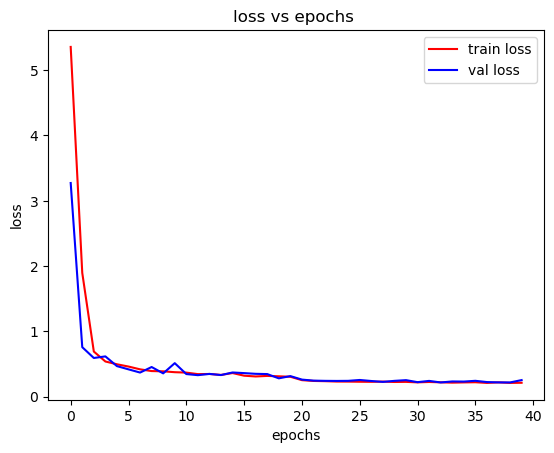

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
#plt.plot(val_mse, 'g', label='val mse')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs ')
plt.legend()
plt.savefig('seq2seq_loss_vs_epochs.png')

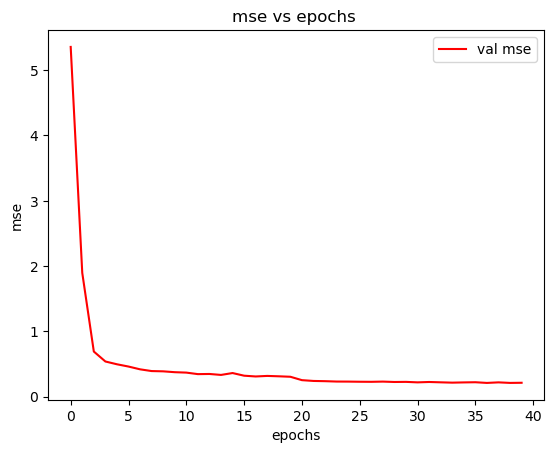

In [31]:
plt.plot(train_loss, 'r', label='val mse')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('mse vs epochs ')
plt.legend()
plt.savefig('seq2seq_val_mse_vs_epochs.png')

In [90]:
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

ValueError: too many values to unpack (expected 2)

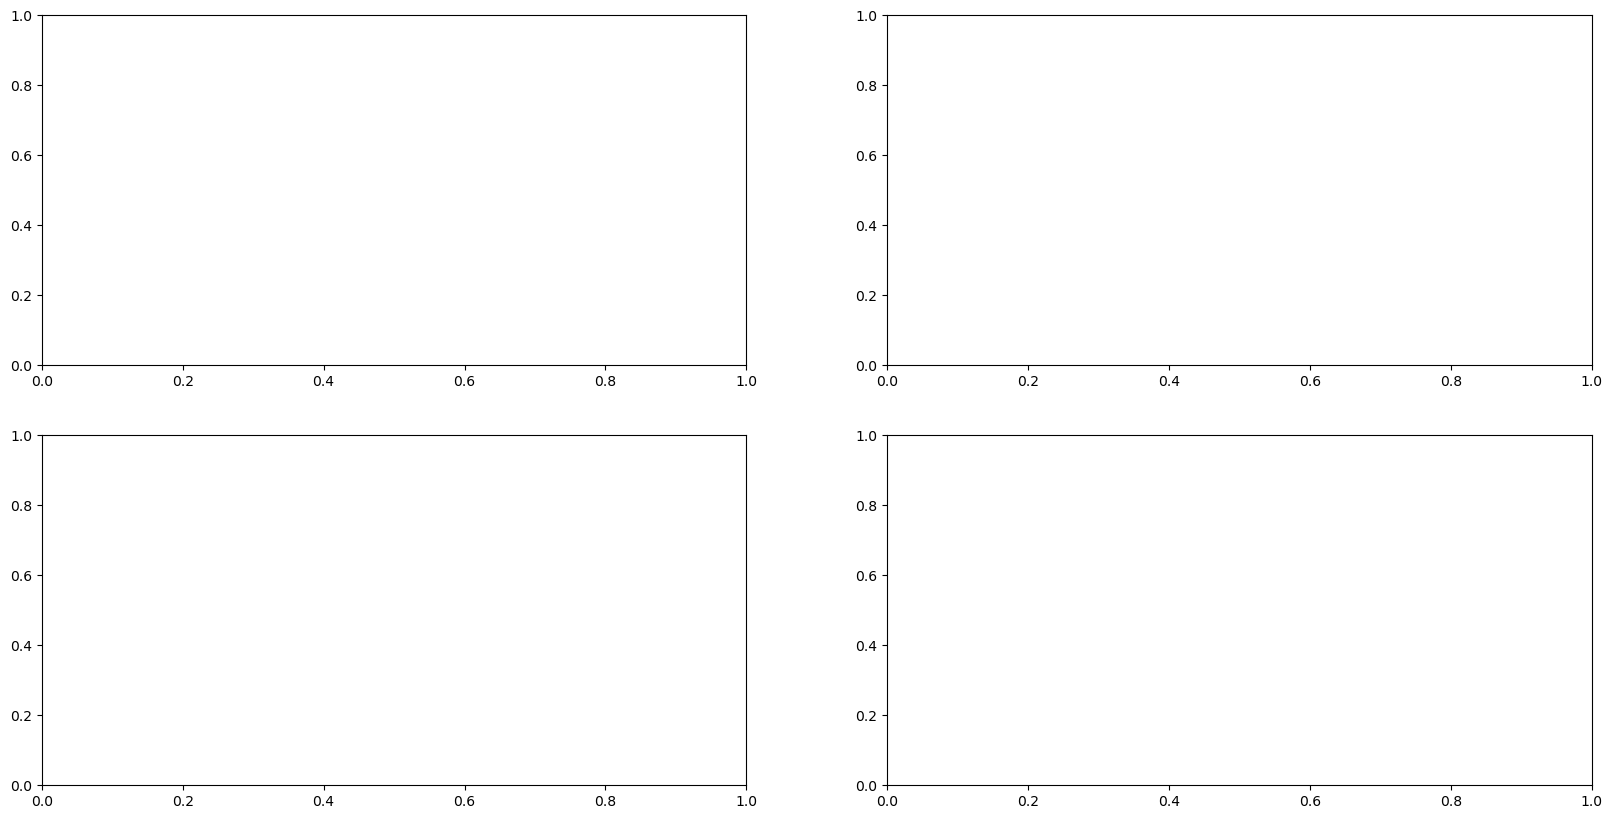

In [119]:
encoder.load_state_dict(torch.load("encoder_best_model.pt"))
decoder.load_state_dict(torch.load("decoder_best_model.pt"))

encoder.eval()
decoder.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    encoder_outputs, encoder_hidden = encoder(batch.x)
    pred = decoder(batch.x, encoder_hidden)
    
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)
    
    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.savefig('seq2seq_pred_true_trajectories.png')
plt.show()

In [319]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

encoder.load_state_dict(torch.load("encoder_best_model.pt"))
decoder.load_state_dict(torch.load("decoder_best_model.pt"))

encoder.eval()
decoder.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        #pred_norm = model(batch)

        encoder_outputs, encoder_hidden1, encoder_hidden2 = encoder(batch.x)
        pred_norm = decoder(batch.x, encoder_hidden1,encoder_hidden2)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('randominprogressattempt.csv', index=True)